<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Creating-the-Dataset" data-toc-modified-id="Creating-the-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the Dataset</a></span></li><li><span><a href="#Checking-Data-Integrity" data-toc-modified-id="Checking-Data-Integrity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking Data Integrity</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Train/Test/Split" data-toc-modified-id="Train/Test/Split-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Train/Test/Split</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#ERROR" data-toc-modified-id="ERROR-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>ERROR</a></span></li><li><span><a href="#Bodyfat" data-toc-modified-id="Bodyfat-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Bodyfat</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Linear-Regresssion" data-toc-modified-id="Linear-Regresssion-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Linear Regresssion</a></span></li><li><span><a href="#Validate" data-toc-modified-id="Validate-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Validate</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#XgB-Regressor" data-toc-modified-id="XgB-Regressor-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>XgB Regressor</a></span></li></ul></li></ul></div>

## Problem

   Knowing one's total proportion of body fat is beneficial both from a health standpoint as well as a cosmetic standpoint. The two most accurate forms of this measurement are through use of a DEXA scanner and/or hydrostatic weighing. Both of those processes are expense and time consuming for the average individual. By using information about patients that have performed those tests, we may be able to find a commonality among these variables that will assist us in making a more affordable and accessible, but still fairly accurate, estimation of a persons body fat percentage. Current algorithms based on easily accessed data are considered only slightly accurate across the population as a whole, but wildly inaccurate to an individual. 

In [1030]:
## Based on the research I have acquired, frame size has a positive correlation to TBF and FFM... Can we improve the current 
## measure of body fat based on bmi or specific measurements by incorporating the frame size into those calculations?

## Introduction

The data set acquired is taken from 252 adult male samples. That being said, any predictions created from it, will likely only apply to the adult male population. I believe it potentially important to create separate models based on gender, and possibly other unforeseen factors to arrive at an estimation of the desired accuracy based on the individual rather than across the population. Each sample in this set has had their total body fat measured through hydrostatic weighing. Density is the resulting column (X*X). With that value it has been plugged into two separate formulas to calculate the proportion (Siri & Brozek) Brozek has shown to be more accurate used on samples that have not had any recent weight fluctuations. 

(I will be using the Brozek Formula, after reviewing the data, Siri dipped into the negatives)

## Creating the Dataset

In [1031]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import math
import numpy as np
import seaborn as sn
pd.set_option('display.max_columns', None)

In [1032]:
#Importing the main dataset
df = pd.read_csv('Bodyfat.csv')

In [1033]:
#Importing an additional dataset with more features to add to the original
df2 = pd.read_csv('fat.dat.txt', header=None, delimiter='\s+')

In [1034]:
#Combining extra features from the additional df (df2)
df['BF_Brozek'] = df2[1]
df['BMI'] = df2[7]
df['FFM_Brozek'] = df2[8]

In [1035]:
#Remove Siri BF and Siri Lean Weight because it is least likely to be accurate having overall lower measurements and samples that 
#had a negative BF %
df.drop(['bodyfat'], axis=1, inplace=True)

In [1036]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6


In [1037]:
## I need to create another column which uses the military measure for bodyfat on each sample

In [1038]:
## the formula used by the DoD is 86.010 x log10(abdomen - neck) - 70.041 x log10(height) + 36.76
# Creating a copy dataset only including the 3 variables used in the DOD measurement 
# Im going to change the measurements to inches for the equation
df3 = df[['Height', 'Neck', 'Abdomen']].copy()

df3['Neck'] = df3['Neck'] * 0.393701
df3['Abdomen'] = df3['Abdomen'] * 0.393701

df3

,Height,Neck,Abdomen
0,67.75,14.251976,33.543325
1,72.25,15.157489,32.677183
2,66.25,13.385834,34.606318
3,72.25,14.724417,34.015766
4,71.25,13.543314,39.370100
...,...,...,...
247,67.00,13.740165,32.913404
248,69.75,16.102371,41.338605
249,66.00,15.314969,43.897662
250,70.50,15.314969,39.881911


In [1039]:
#Using the DoD formula against all samples to create a list of body fat percentages and then adding it as a column to df3

bf = []
ans1 = []
ans2 = []

for x in df3['Height']:
    ans2.append(np.log10(x))

for x in df3['Abdomen']:
    for y in df3['Neck']:
        ans1.append(np.log10(x-y))
        
answers = zip(ans1, ans2)

for x, y in answers:
    bf.append(round(86.010 * x - 70.041 * y + 36.76, 2))
print(bf)

df3['DoD_BF'] = bf
df3['Brozek'] = df['BF_Brozek']
df3

[19.08, 15.32, 21.4, 16.19, 18.89, 13.89, 18.04, 15.77, 14.91, 11.81, 14.39, 13.06, 16.58, 15.02, 14.87, 19.72, 15.53, 12.86, 17.68, 13.58, 16.68, 14.08, 20.57, 18.61, 20.35, 17.82, 19.19, 17.15, 20.3, 18.14, 14.54, 16.7, 16.07, 14.8, 11.81, 18.62, 16.29, 14.06, 3.47, 16.23, 12.87, 44.06, 17.23, 13.16, 22.38, 17.08, 21.12, 18.74, 21.25, 21.17, 18.1, 19.94, 18.85, 17.43, 17.95, 14.29, 16.68, 14.87, 14.33, 18.27, 12.51, 19.2, 16.58, 18.49, 14.98, 15.42, 18.21, 16.9, 17.4, 17.36, 17.97, 16.67, 16.34, 23.03, 19.76, 19.34, 16.34, 16.78, 16.73, 17.48, 17.36, 17.82, 14.47, 16.13, 16.61, 18.96, 18.14, 19.76, 15.62, 16.42, 17.31, 15.94, 16.86, 15.93, 15.34, 10.95, 15.7, 17.69, 19.08, 14.21, 13.5, 16.61, 17.47, 12.9, 15.72, 22.44, 14.72, 11.58, 13.98, 19.9, 17.97, 17.39, 14.9, 18.65, 15.93, 18.33, 16.45, 13.37, 14.75, 15.72, 12.5, 14.83, 18.09, 18.99, 18.48, 19.11, 16.51, 18.07, 13.85, 16.55, 17.97, 17.79, 15.46, 18.29, 18.07, 16.95, 17.14, 15.23, 18.96, 12.3, 16.72, 18.07, 18.07, 17.65, 13.59, 

,Height,Neck,Abdomen,DoD_BF,Brozek
0,67.75,14.251976,33.543325,19.08,12.6
1,72.25,15.157489,32.677183,15.32,6.9
2,66.25,13.385834,34.606318,21.40,24.6
3,72.25,14.724417,34.015766,16.19,10.9
4,71.25,13.543314,39.370100,18.89,27.8
...,...,...,...,...,...
247,67.00,13.740165,32.913404,20.39,11.5
248,69.75,16.102371,41.338605,14.42,32.3
249,66.00,15.314969,43.897662,17.75,28.3
250,70.50,15.314969,39.881911,15.75,25.3


In [1040]:
# Adding a colummn for the error between actual and DoD measurement
df3['Error'] = df3['DoD_BF'] - df3['Brozek']
df['Error'] = df3['Error']

In [1041]:
df3

,Height,Neck,Abdomen,DoD_BF,Brozek,Error
0,67.75,14.251976,33.543325,19.08,12.6,6.48
1,72.25,15.157489,32.677183,15.32,6.9,8.42
2,66.25,13.385834,34.606318,21.40,24.6,-3.20
3,72.25,14.724417,34.015766,16.19,10.9,5.29
4,71.25,13.543314,39.370100,18.89,27.8,-8.91
...,...,...,...,...,...,...
247,67.00,13.740165,32.913404,20.39,11.5,8.89
248,69.75,16.102371,41.338605,14.42,32.3,-17.88
249,66.00,15.314969,43.897662,17.75,28.3,-10.55
250,70.50,15.314969,39.881911,15.75,25.3,-9.55


## Checking Data Integrity

The minimum essential amount of body fat required for life in a male is 2-5% 

In [1042]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Density     252 non-null    float64
 1   Age         252 non-null    int64  
 2   Weight      252 non-null    float64
 3   Height      252 non-null    float64
 4   Neck        252 non-null    float64
 5   Chest       252 non-null    float64
 6   Abdomen     252 non-null    float64
 7   Hip         252 non-null    float64
 8   Thigh       252 non-null    float64
 9   Knee        252 non-null    float64
 10  Ankle       252 non-null    float64
 11  Biceps      252 non-null    float64
 12  Forearm     252 non-null    float64
 13  Wrist       252 non-null    float64
 14  BF_Brozek   252 non-null    float64
 15  BMI         252 non-null    float64
 16  FFM_Brozek  252 non-null    float64
 17  Error       252 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 35.6 KB


In [1043]:
## 171 and 181 have estimated bf percentages lower than 2%, which is required for life. I can either remove these as inaccurate or test a model 
## increasing the estimate bf by 2 for all. I would like to find the measurements responsible for the inaccuracies and maybe remove or alter
## them for a model.

In [1044]:
## Should I remove the two Obese measurements? With there only being 2 will it negatively impact my model?

In [1045]:
## check all density within a certain range

## Feature Engineering

In [1046]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,8.42
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,8.89
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55


In [1047]:
## Creating a column for wrist measurement in inches form centimeters and then to create a column for body frame size based on that measurement. 
## See readme for body frame category measurements

df['Wrist_Inches'] = round(df['Wrist'] * 0.393701,2)

In [1048]:
## Creating the frame column

wrist_inches = pd.array(df['Wrist_Inches'])

In [1049]:
## Going to use -1 for small, 0 for medium, and 1 for large frames

frame = []

for x in wrist_inches:
    if x > 7.5:
        frame.append(1)
    elif x <= 7.5 and x >= 6.5:
        frame.append(0)
    else:
        frame.append(-1)

In [1050]:
## Checking accuracy

len(frame)

252

In [1051]:
## adding the frame column
df['Frame'] = DataFrame(frame, columns=['Frame'])

In [1052]:
df[df['Frame'] == 1].mean()

Density           1.045043
Age              47.809524
Weight          212.997619
Height           71.845238
Neck             40.985714
Chest           109.850000
Abdomen         103.111905
Hip             106.526190
Thigh            63.580952
Knee             40.902381
Ankle            24.497619
Biceps           35.335714
Forearm          30.338095
Wrist            19.645238
BF_Brozek        23.602381
BMI              28.995238
FFM_Brozek      161.852381
Error           -10.184048
Wrist_Inches      7.735476
Frame             1.000000
dtype: float64

In [1053]:
## adding knee in inches column
df['Knee_Inches'] = round(df['Knee'] * 0.393701,2)

In [1054]:
# assuming men carry fat mostly in their upper bodies I wonder how the ankle to their thigh, or wrist to abdomen ration
# affects, or ankle to abdomen/hip

In [1055]:
#side note i wonder if the breadth/circumference ratio can predict body fat also maybe when flexed (ex. measuring height of
#muscle in bicep in ratio to the circuference around when flexed, breadth of forearm vs circumference) fat would be more circular
#0.5/more muscle would be more oval 

In [1056]:
df['HW_ratio'] = round(df['Abdomen'] / df['Hip'], 2)

In [1057]:
df['abs_weight'] = round(df['Abdomen'] / df['Weight'], 2)

In [1058]:
df['hip_weight'] = round(df['Hip'] / df['Weight'], 2)

In [1059]:
df['abs_height'] = round(df['Abdomen'] / df['Height'], 2)

In [1060]:
df['thigh_hip'] = round(df['Thigh'] / df['Hip'], 2)

In [1061]:
df['thigh_abs'] = round(df['Thigh'] / df['Abdomen'], 2)

In [1062]:
df['chest_abs'] = round(df['Chest'] / df['Abdomen'], 2)

In [1063]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48,6.73,0,14.69,0.90,0.55,0.61,1.26,0.62,0.69,1.09
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,8.42,7.17,0,14.69,0.84,0.48,0.57,1.15,0.59,0.71,1.13
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20,6.54,0,15.31,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29,7.17,0,14.69,0.85,0.47,0.55,1.20,0.59,0.70,1.18
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91,6.97,0,16.61,0.98,0.54,0.55,1.40,0.62,0.63,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,8.89,7.28,0,13.70,0.94,0.62,0.66,1.25,0.56,0.59,1.07
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88,7.91,1,16.06,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55,7.09,0,14.69,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55,7.80,1,16.38,1.04,0.53,0.51,1.44,0.57,0.55,1.07


## Analysis

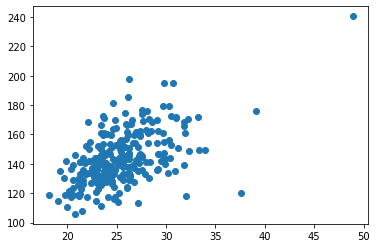

In [1064]:
# correlation of BMI to FFM
plt.scatter(df['BMI'], df['FFM_Brozek'])

In [1065]:
#Removing the one outlier extremely obese
df.drop(38, axis=0)

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48,6.73,0,14.69,0.90,0.55,0.61,1.26,0.62,0.69,1.09
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,8.42,7.17,0,14.69,0.84,0.48,0.57,1.15,0.59,0.71,1.13
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20,6.54,0,15.31,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29,7.17,0,14.69,0.85,0.47,0.55,1.20,0.59,0.70,1.18
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91,6.97,0,16.61,0.98,0.54,0.55,1.40,0.62,0.63,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,8.89,7.28,0,13.70,0.94,0.62,0.66,1.25,0.56,0.59,1.07
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88,7.91,1,16.06,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55,7.09,0,14.69,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55,7.80,1,16.38,1.04,0.53,0.51,1.44,0.57,0.55,1.07


In [1066]:
df[(df['Error'] < -8)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91,6.97,0,16.61,0.98,0.54,0.55,1.40,0.62,0.63,0.97
16,1.0333,34,195.75,71.00,38.9,101.9,96.4,105.2,64.8,40.8,23.1,36.2,30.8,17.3,28.1,27.3,140.8,-12.57,6.81,0,16.06,0.92,0.49,0.54,1.36,0.62,0.67,1.06
17,1.0468,32,209.25,71.00,42.1,107.6,97.5,107.0,66.9,40.0,24.4,38.2,31.6,19.3,22.4,29.2,162.5,-9.54,7.60,1,15.75,0.91,0.47,0.51,1.37,0.63,0.69,1.10
34,1.0263,41,247.25,73.50,42.1,117.0,115.6,116.1,71.2,43.3,26.3,37.3,31.7,19.7,31.1,32.2,170.4,-19.29,7.76,1,17.05,1.00,0.47,0.47,1.57,0.61,0.62,1.01
35,1.0101,49,191.75,65.00,38.4,118.5,113.1,113.8,61.9,38.3,21.9,32.0,29.8,17.0,38.2,32.0,118.4,-19.58,6.69,0,15.08,0.99,0.59,0.59,1.74,0.54,0.55,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1.0308,69,215.50,70.50,40.8,113.7,107.6,110.0,63.3,44.0,22.6,37.5,32.6,18.8,29.1,30.5,152.7,-14.92,7.40,0,17.32,0.98,0.50,0.51,1.53,0.58,0.59,1.06
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88,7.91,1,16.06,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55,7.09,0,14.69,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55,7.80,1,16.38,1.04,0.53,0.51,1.44,0.57,0.55,1.07


In [1067]:
df[(df['Error'] > -8) & (df['Error'] < 8)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48,6.73,0,14.69,0.90,0.55,0.61,1.26,0.62,0.69,1.09
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20,6.54,0,15.31,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29,7.17,0,14.69,0.85,0.47,0.55,1.20,0.59,0.70,1.18
5,1.0502,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8,20.6,26.5,167.0,-6.71,7.40,0,16.54,0.88,0.45,0.51,1.26,0.61,0.70,1.11
6,1.0549,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7,19.0,26.2,146.6,-0.96,6.97,0,15.08,0.90,0.50,0.55,1.30,0.58,0.64,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1.0384,58,161.75,67.25,35.1,94.9,94.9,100.2,56.8,35.9,21.0,27.8,26.1,17.6,25.9,25.2,119.9,-5.77,6.93,0,14.13,0.95,0.59,0.62,1.41,0.57,0.60,1.00
235,1.0563,62,168.75,67.50,38.3,104.7,95.6,93.7,54.4,37.1,22.7,30.3,26.3,18.3,18.4,26.1,137.6,-0.85,7.20,0,14.61,1.02,0.57,0.56,1.42,0.58,0.57,1.10
238,1.0705,64,155.25,69.50,37.9,95.8,82.8,94.5,61.2,39.1,22.3,29.8,28.9,18.3,12.7,22.6,135.5,4.28,7.20,0,15.39,0.88,0.53,0.61,1.19,0.65,0.74,1.16
240,1.0599,65,127.50,65.75,34.7,93.0,79.7,87.6,50.7,33.4,20.1,28.5,24.8,16.5,17.0,20.8,105.9,4.11,6.50,0,13.15,0.91,0.63,0.69,1.21,0.58,0.64,1.17


In [1068]:
# Findings DoD underestimates low h/r and bmi, weight values 
# Dod overestimations have bmis higher than __ and h/r higher than __
# dod scores well on bmis around 24-26 and h/r 
# thigh/abs, chest/abs, biceps/abs all play a role
# men with higher actual BF than DOD had larger thighs 
# lower actual BFs had smaller thighs
# everything in ratio to abs (abs smaller = lower bf, abs equal = higher bf, abs bigger = lower bf )
# abdomen to wieght? low body fat will have a small waist but higher wieght and higher bf will have a larger waist with larger weight
# same with hips to weight depending on their waist to hip ratio

In [1069]:
#heatmap/correlation
corr = abs(df.corr(method='pearson')) > 0.8
corr

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
Density,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
Age,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,False,True,False,True,True,True,True,True,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False
Height,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neck,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
Chest,False,False,True,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
Abdomen,False,False,True,False,False,True,True,True,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,False
Hip,False,False,True,False,False,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
Thigh,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Knee,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False


In [1070]:
#findings - maybe use hip, h/w, neck
## Results - hip/weight, chest/bmi
# we could potentially use the error or FFM as the dependent variable as well to get BF

In [1071]:
#Create the df using to model
model_df = df.copy()

In [1083]:
#remove density and unecessary columns... correlates with the Brozek score
model_df.drop(['Density', 'Wrist_Inches', 'Knee_Inches', 'FFM_Brozek'], axis=1, inplace=True)

KeyError: "['Density' 'Wrist_Inches' 'Knee_Inches' 'FFM_Brozek'] not found in axis"

In [1084]:
#creating separate df for Error
error_df = model_df.copy()

In [1074]:
abs(model_df.corr(method='spearman')) > 0.80

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,Error,Frame,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
Age,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,True,False,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
Height,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neck,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
Chest,False,True,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False
Abdomen,False,True,False,False,True,True,True,False,False,False,False,False,False,True,True,True,False,True,False,True,True,False,False,False
Hip,False,True,False,False,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
Thigh,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Knee,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ankle,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [1075]:
## How do fat free weight and wrist measurement correlate?
## There is a previous correlation of 0.59 according to attached research paper
## According to the same paper, the knee measurement, which we have, had a correlation of 0.65 to FFM and 0.48 TBF and 0.71 Weight
## If the person has had a recent significant weight loss, using bone measurements would not be as accurate on them

In [1076]:
## Remove older samples maybe having a lower bone density? Cannot remove if using previous research paper as they used samples from ages 18-65.


In [1077]:
## skin estimated to be 16% of weight and intestines 7.5lbs
## https://www.livescience.com/32939-how-much-does-skin-weigh.html#:~:text=As%20an%20organ%2C%20skin%20is,a%20person's%20total%20body%20weight.&text=Most%20adults'%20skin%20weighs%20in%20at%2020%20pounds%20or%20more.
## other organs 9.3 pounds mean with no correlation to height weight or bmi of man, so the mean is the best fidure to use
## https://journals.lww.com/amjforensicmedicine/Abstract/2012/12000/Normal_Organ_Weights_in_Men__Part_II_The_Brain,.22.aspx#:~:text=The%20following%20reference%20ranges%20(95,the%20presence%20of%20pathologic%20disease.

In [1078]:
## group the samples into error rates >8, <-8, 8>-8 -- then find similiarities or patterns

## Preprocessing

### Train/Test/Split

In [1114]:
## Split Training and Testing Data
from sklearn.model_selection import train_test_split

BF_df = model_df.copy()
y = BF_df[['BF_Brozek']]
X = BF_df.drop(['BF_Brozek', 'Error'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [1115]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [1085]:
## Split using Error as the dependent feature

err_y = error_df[['Error']]
err_X = error_df.drop(['Error','BF_Brozek'], axis=1)
err_X_train, err_X_test, err_y_train, err_y_test = train_test_split(err_X, err_y, test_size=0.25, random_state=0)

In [ ]:
scale = MinMaxScaler()
err_X_train_scaled = scale.fit_transform(err_X_train)
err_X_test_scaled = scale.transform(err_X_test)

### Feature Selection

#### ERROR

In [1101]:
ridge = Ridge(alpha=0.05)
ridge.fit(err_X_train_scaled, err_y_train)

lasso = Lasso(alpha=0.05)
lasso.fit(err_X_train_scaled, err_y_train)

lin = LinearRegression()
lin.fit(err_X_train_scaled, err_y_train)

LinearRegression()

In [1102]:
err_y_h_ridge_train = ridge.predict(err_X_train_scaled)
err_y_h_ridge_test = ridge.predict(err_X_test_scaled)

err_y_h_lasso_train = np.reshape(lasso.predict(err_X_train_scaled), (189, 1))
err_y_h_lasso_test = np.reshape(lasso.predict(err_X_test_scaled), (63, 1))

err_y_h_lin_train = lin.predict(err_X_train_scaled)
err_y_h_lin_test = lin.predict(err_X_test_scaled)

In [1103]:
print('Train Error Ridge Model', np.sum((err_y_train - err_y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((err_y_test - err_y_h_ridge_test)**2))
print('\n')

print('Train Error Lasso Model', np.sum((err_y_train - err_y_h_lasso_train)**2))
print('Test Error Lasso Model', np.sum((err_y_test - err_y_h_lasso_test)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((err_y_train - lin.predict(err_X_train_scaled))**2))
print('Test Error Unpenalized Linear Model', np.sum((err_y_test - lin.predict(err_X_test_scaled))**2))

Train Error Ridge Model Error    2865.595445
dtype: float64
Test Error Ridge Model Error    846.927635
dtype: float64


Train Error Lasso Model Error    3416.608178
dtype: float64
Test Error Lasso Model Error    883.79642
dtype: float64


Train Error Unpenalized Linear Model Error    2775.279699
dtype: float64
Test Error Unpenalized Linear Model Error    823.472532
dtype: float64


In [1096]:
print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', lasso.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [[ -1.00218503  -5.10339092  -8.42843588  -7.98277477  -4.10225863
   -4.94773884   0.82291973   0.61845844  -4.03636276  -1.99507452
    3.48833951  -5.34106438   3.47869082  -2.08899597   0.85448086
  -12.1350266    4.16699013  12.07575233   3.76421048   9.95928759]]
Lasso parameter coefficients: [ -0.          -2.17365941 -19.90667446  -0.          -0.
  -0.          -0.          -0.          -4.14535753  -0.
   0.          -0.           0.          -0.          -0.
 -11.63639491   3.37145723   2.10673171   0.          14.79669665]
Linear model parameter coefficients: [[ 4.02489980e+01 -9.37794455e+00 -3.60294751e+01 -3.73749684e+01
  -2.14635568e+01  3.54131262e+01 -6.29004536e+02 -5.22241464e-01
  -4.45566567e+00 -1.04871344e+00  4.18346374e+01 -6.17192381e+00
  -3.21896791e+01 -2.99451884e+00  6.30959989e+02 -1.09844903e+01
   1.28800231e+01  2.69831775e+01 -2.48537495e+01  2.57338120e+01]]


ridge = Ridge(alpha=0.5)
ridge.fit(err_X_train_scaled, err_y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(err_X_train_scaled, err_y_train)

lin = LinearRegression()
lin.fit(err_X_train_scaled, err_y_train)

In [ ]:
# Lassoed features - Weight, Height, Knee, hip/weight, abs/height, thigh/hip, chest/abs

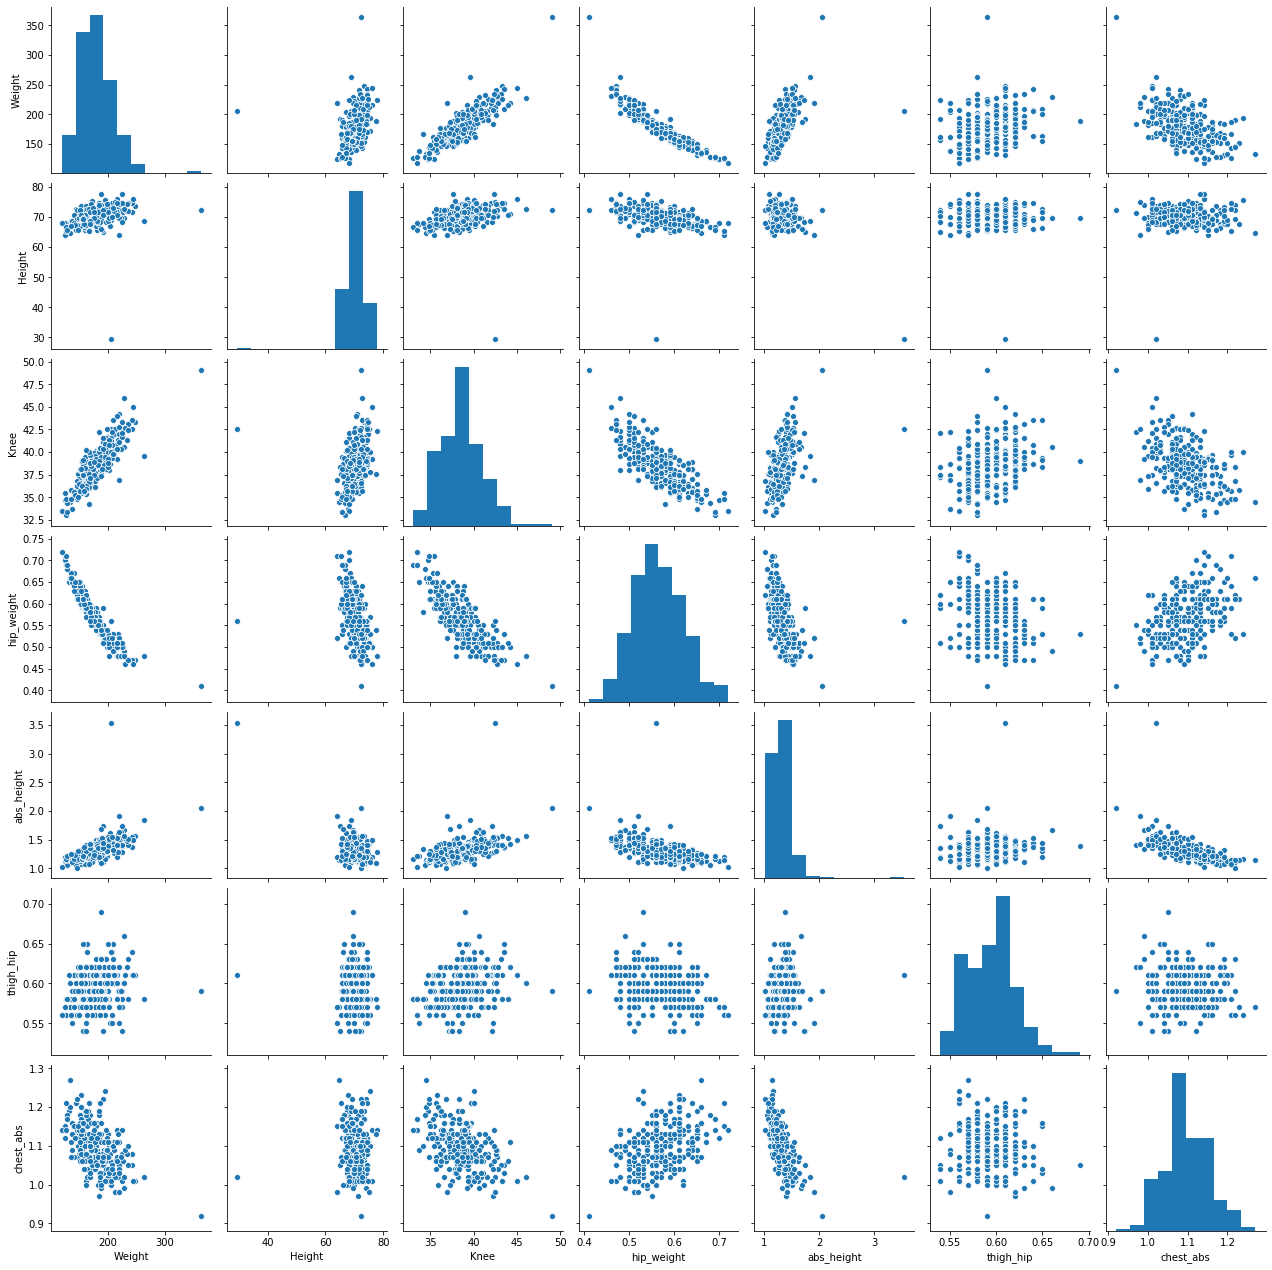

In [1146]:
linear_Error = error_df[['Weight', 'Height', 'Knee', 'hip_weight', 'abs_height', 'thigh_hip', 'chest_abs']]
print(sns.pairplot(linear_Error))

#### Bodyfat

In [1122]:
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_scaled, y_train)

lasso = Lasso(alpha=0.05)
lasso.fit(X_train_scaled, y_train)

lin = LinearRegression()
lin.fit(X_train_scaled, y_train)

LinearRegression()

In [1123]:
err_y_h_ridge_train = ridge.predict(X_train_scaled)
err_y_h_ridge_test = ridge.predict(X_test_scaled)

err_y_h_lasso_train = np.reshape(lasso.predict(X_train_scaled), (189, 1))
err_y_h_lasso_test = np.reshape(lasso.predict(X_test_scaled), (63, 1))

err_y_h_lin_train = lin.predict(X_train_scaled)
err_y_h_lin_test = lin.predict(X_test_scaled)

In [1124]:
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train_scaled))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test_scaled))**2))

Train Error Ridge Model BF_Brozek    103931.899537
dtype: float64
Test Error Ridge Model BF_Brozek    28341.022292
dtype: float64


Train Error Lasso Model BF_Brozek    103282.707143
dtype: float64
Test Error Lasso Model BF_Brozek    28953.637743
dtype: float64


Train Error Unpenalized Linear Model BF_Brozek    2771.406651
dtype: float64
Test Error Unpenalized Linear Model BF_Brozek    5086.430783
dtype: float64


In [1125]:
print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', lasso.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [[ 2.51024145 -1.1151772  -1.7586861  -5.05066098  5.75500994  5.45363961
   3.25517712  3.04902137  1.33203211  3.10254235  2.90810164  2.78633434
  -7.2453052   1.99615767  1.5849125   8.50139298  2.83869228 -2.96887037
   7.2090461   2.46585817 -3.25368374 -7.05805358]]
Lasso parameter coefficients: [ 0.          0.          0.         -0.          2.31317547  0.
  0.          0.          0.          0.          1.19829854  0.
 -0.75679207  0.         -0.         12.07300277 -0.         -0.
 18.97960941  0.73187498 -0.         -6.35761723]
Linear model parameter coefficients: [[  2.96753599 -86.41310412   1.82528941  -5.35237514   5.27377186
   69.76903833  53.32677811 -30.89641079   0.34582533   6.13722046
    4.49634179   3.76576069 -10.27365068  31.3629754    4.15237445
   19.17366437  -0.29662933 -10.41903665 -29.154805     5.37280133
   13.43774996  -4.61287661]]


In [1126]:
# Lasso Features - Chest, Biceps, Wrist, H/W ratio, abs/height, thigh/hip, chest/abs

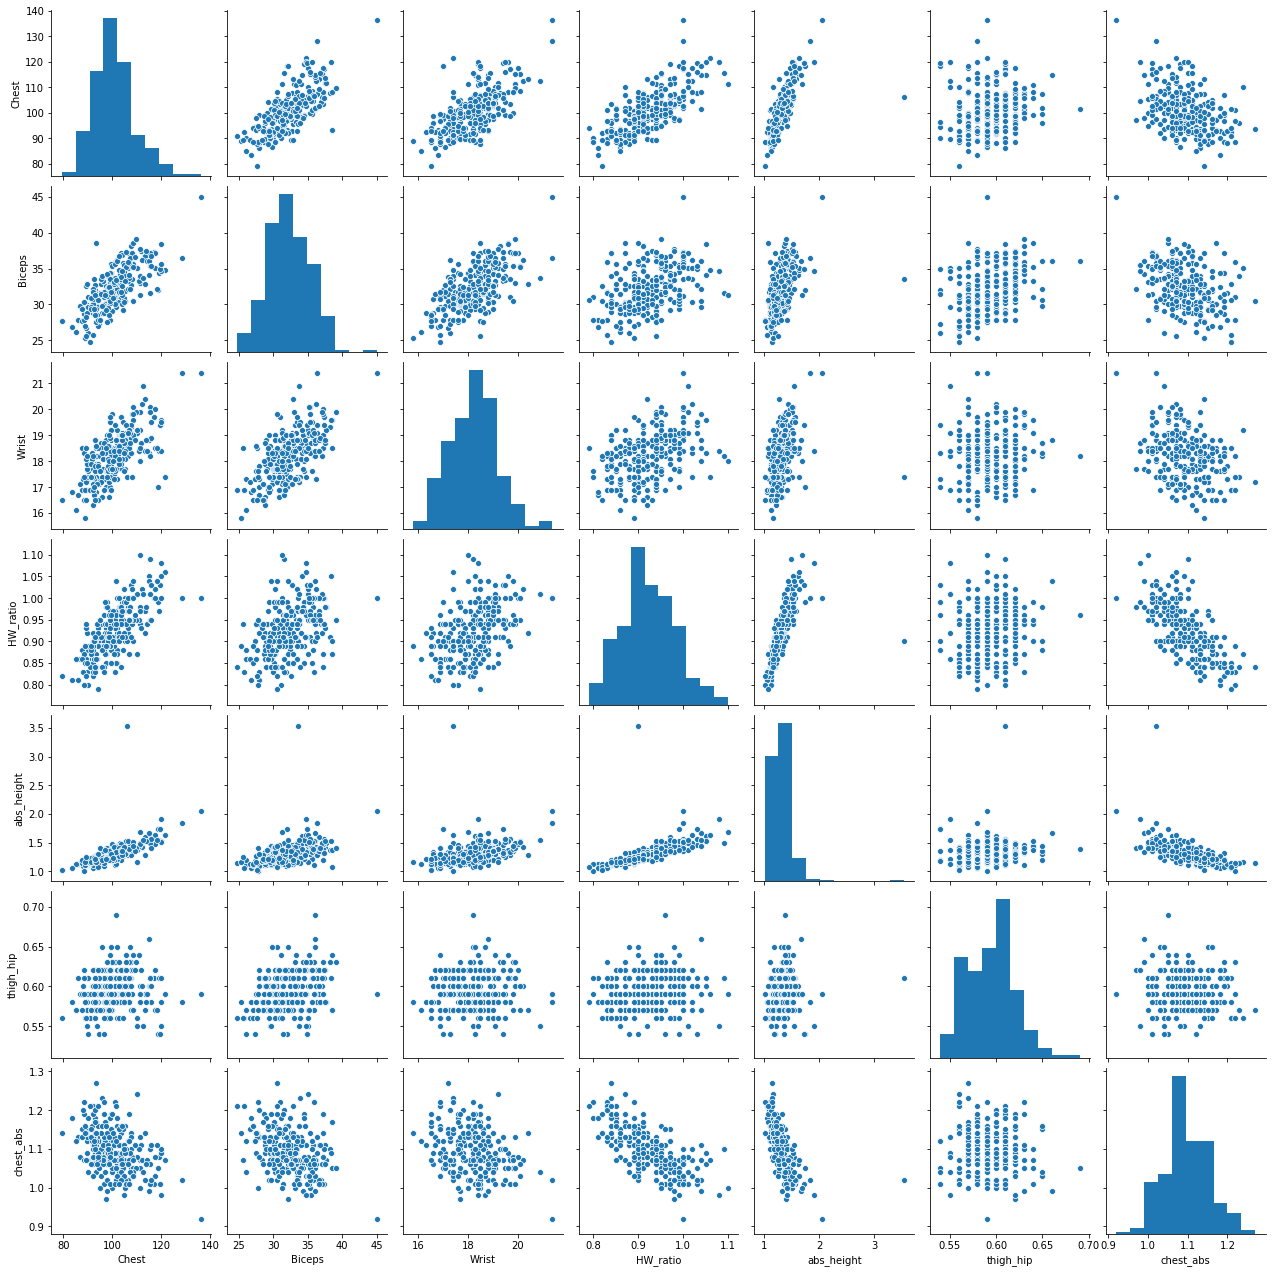

In [1143]:
linear_BF = BF_df[['Chest', 'Biceps', 'Wrist', 'HW_ratio', 'abs_height', 'thigh_hip', 'chest_abs']]
print(sns.pairplot(linear_BF))


In [1130]:
z = err_X['Abdomen']
d = err_y['Error']

In [1131]:
cor_matrix = np.corrcoef(z, d)
print(cor_matrix[0,1])

-0.8752569064386132


## Modeling

In [1135]:
x_col = list(X.columns)

In [1133]:
from statsmodels.formula.api import ols


# Fitting the actual model
for x in x_col:
    predictors = x
    outcome = 'BF_Brozek'
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=BF_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BF_Brozek   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     22.81
Date:                Mon, 02 Nov 2020   Prob (F-statistic):           3.04e-06
Time:                        04:33:08   Log-Likelihood:                -862.11
No. Observations:                 252   AIC:                             1728.
Df Residuals:                     250   BIC:                             1735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9555      1.736      6.312      0.0

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
Dep. Variable:              BF_Brozek   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     281.9
Date:                Mon, 02 Nov 2020   Prob (F-statistic):           7.14e-43
Time:                        04:33:08   Log-Likelihood:                -777.99
No. Observations:                 252   AIC:                             1560.
Df Residuals:                     250   BIC:                             1567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [1134]:
# Fitting the actual model
for x in x_col:
    predictors = x
    outcome = 'Error'
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=err_df).fit()
    print(model.summary())

NameError: name 'err_df' is not defined

In [ ]:
predictors = '+'.join(['Chest', 'HW_ratio', 'Knee'])
outcome = 'Error'
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
print(model.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xv = model_df[x_col].drop(['Height', 'Age', 'Frame', 'Thigh', 'hip_weight', 'thigh_abs', 'Abdomen', 'Hip', 'Weight', 'abs_weight', 'thigh_hip', 'Wrist', 'Neck', 'Knee', 'Chest', 'Forearm'], axis=1)
vif = [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]
list(zip(Xv.columns, vif))

### Linear Regresssion

In [1087]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

print('Training r^2:', linreg_all.score(X_train, y_train))
print('Test r^2:', linreg_all.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, linreg_all.predict(X_test)))

Training r^2: 0.9925483079211985
Test r^2: 0.768957799374947
Training MSE: 0.44761193882933914
Test MSE: 12.991652545191984


In [1088]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg_all = LinearRegression()
linreg_all.fit(err_X_train, err_y_train)

print('Training r^2:', linreg_all.score(err_X_train, err_y_train))
print('Test r^2:', linreg_all.score(err_X_test, err_y_test))
print('Training MSE:', mean_squared_error(err_y_train, linreg_all.predict(err_X_train)))
print('Test MSE:', mean_squared_error(err_y_test, linreg_all.predict(err_X_test)))

Training r^2: 0.8206104789034814
Test r^2: 0.8390822924858122
Training MSE: 14.417551534291666
Test MSE: 13.21726600453138


### Validate

### Random Forest Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

In [ ]:
RandomForestRegressor(max_depth=6, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=150)

In [ ]:
tree_clf = RandomForestRegressor(n_estimators=150, max_depth=6, max_features=3, min_samples_leaf=3, min_samples_split=8, random_state=0) 
tree_clf.fit(err_X_train, err_y_train)

In [ ]:
y_pred = tree_clf.predict(err_X_test)
y_pred

In [ ]:
mse = mean_squared_error(err_y_test, y_pred)
r2 = r2_score(err_y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print(r2)

In [ ]:
tree_clf.feature_importances_

In [ ]:
def plot_feature_importances(model):
    n_features = err_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), err_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [ ]:
# Test set predictions
pred = tree_clf.predict(err_X_test)

# Regression report
print(tree_clf.score(err_X, err_y))


In [ ]:
print(tree_clf.get_params)

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(tree_clf.get_params())

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [ ]:
#gsc = GridSearchCV()

In [ ]:
#grid_result = gsc.fit(err_X, err_y)
#best_params = grid_result.best_params_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:

#rf = RandomForestRegressor()

#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)

#rf_random.fit(err_X_train, err_y_train)

In [ ]:
#rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 6, 7, 8],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 150]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = None, verbose = 2)


In [ ]:

grid_search.fit(err_X_train, err_y_train)

In [ ]:
# Fit the grid search to the data

grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
best_grid





### XgB Regressor

In [ ]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

In [ ]:
xgbr1 = xgb.XGBRegressor(verbosity=0)
xgbr1.fit(X_train, y_train)
score1 = xgbr1.score(X_train, y_train)
score2 = xgbr1.score(X_test, y_test)
score2

In [ ]:
ypred1 = xgbr1.predict(X_test)
mse1 = mean_squared_error(y_test, ypred1)
print("MSE: %.2f" % mse1)

print("RMSE: %.2f" % (mse1*(1/2.0)))

In [ ]:
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)

In [ ]:
xgbr.fit(err_X_train, err_y_train)

In [ ]:
score = xgbr.score(err_X_train, err_y_train)  
print("Training score: ", score)


In [ ]:
scores = cross_val_score(xgbr, err_X_train, err_y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, err_X_train, err_y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [ ]:
ypred = xgbr.predict(err_X_test)
mse = mean_squared_error(err_y_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse*(1/2.0)))


In [ ]:
x_ax = range(len(err_y_test))
plt.plot(x_ax, err_y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Real vs Predicted")
plt.legend()
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

%matplotlib inline

In [ ]:
rfc=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(err_X_train, err_y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1=RandomForestRegressor(random_state=42, max_features='auto', n_estimators= 200, max_depth=8)
rfc1.fit(err_X_train, err_y_train)

In [ ]:
pred=rfc1.predict(err_X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(err_y_test,pred))